In [1]:
import os
import gc
import json
import unidecode
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import VGG19_Weights

import optuna
import wandb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from datetime import datetime

import import_ipynb

######## 

from DATA_AND_MODELS import VanGoghDataset,VanGoghModel

wandb.login(key='ba8ed449ca151ad3f490026aec87d75b7171a16d')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/gabriel/.netrc
wandb: Currently logged in as: gabi-dadashev (gabi-dadashev-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
def early_stop_check(patience, best_val_loss, best_val_loss_epoch, current_val_loss, current_val_loss_epoch):
    early_stop_flag = False  
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_val_loss_epoch = current_val_loss_epoch
    else:
        if current_val_loss_epoch - best_val_loss_epoch > patience:
            early_stop_flag = True  
    return best_val_loss, best_val_loss_epoch, early_stop_flag


In [3]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience):
    print('train_model_with_hyperparams')
    
    best_val_loss = float('inf')
    best_val_loss_epoch = 0  
    early_stop_flag = False
    best_model_state = None  

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1s = []
    val_aucs = []

    for epoch in range(1, epochs + 1):
        
        ### Training Loop
        model.train() 
        epoch_train_loss = 0.0 
        total_train_samples = 0 
        correct_train_predictions = 0 
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            
            outputs = model(inputs).squeeze(1)  
            loss = criterion(outputs.view(-1), labels)
            loss.backward() 
            optimizer.step()  

            epoch_train_loss += loss.item() * inputs.size(0)
            total_train_samples += inputs.size(0)
            
            preds_train = (outputs > 0.5).float()
            correct_train_predictions += (preds_train == labels).sum().item()

        epoch_train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ### Validation Loop
        model.eval()  
        epoch_val_loss = 0.0 
        total_val_samples = 0 
        correct_val_predictions = 0

        all_val_labels = []
        all_val_preds = []
        all_val_probs = []

        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze(1)  # outputs shape: (batch_size)
                loss = criterion(outputs.view(-1), labels)

                epoch_val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)
                
                preds = (outputs > 0.5).float()
                
                correct_val_predictions += (preds == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
                all_val_probs.extend(outputs.cpu().numpy())

        epoch_val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples

        if len(np.unique(all_val_labels)) > 1:
            val_f1 = f1_score(all_val_labels, all_val_preds)
            val_auc = roc_auc_score(all_val_labels, all_val_probs)
        else:
            val_f1 = 0
            val_auc = 0

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        best_val_loss, best_val_loss_epoch, early_stop_flag = early_stop_check(patience, best_val_loss, best_val_loss_epoch, epoch_val_loss, epoch)
        if epoch_val_loss == best_val_loss:
            best_model_state = model.state_dict()

        print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Acc = {val_accuracy:.4f}, Val F1 = {val_f1:.4f}, Val AUC = {val_auc:.4f}")

        if early_stop_flag: 
            break 

    if best_model_state is not None: 
        now = datetime.now()
        torch.save(best_model_state, f"best_model_trial_{now.strftime('%H:%M:%S')}.pt") 

    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, val_f1s, label="Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_aucs, label="Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Validation AUC")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_val_loss


In [4]:
classes = pd.read_csv("classes.csv", encoding="utf-8")
classes=classes[['filename', 'artist', 'genre', 'description', 'phash', 'width','height', 'genre_count']].copy()
classes_only_post_impressionism = classes[classes["filename"].str.contains('Post_Impressionism', case=False, na=False)].copy()
classes_only_post_impressionism['is_van_gogh'] = np.where(classes_only_post_impressionism['artist'] == 'vincent van gogh', 1, 0)
classes_only_post_impressionism=classes_only_post_impressionism.reset_index(drop=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [5]:
dataset = VanGoghDataset(dataframe=classes_only_post_impressionism)

model_VGG19 = VanGoghModel(device,None,'VGG19').model
model_Alex = VanGoghModel(device,None,'AlexNet').model

***Train VGG19***

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


--- Fold 1/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6940, Val Loss = 0.6931, Train Acc = 0.8398, Val Acc = 0.8487, Val F1 = 0.0000, Val AUC = 0.7605
Epoch 2: Train Loss = 0.6933, Val Loss = 0.6931, Train Acc = 0.8385, Val Acc = 0.8487, Val F1 = 0.0000, Val AUC = 0.7873
Epoch 3: Train Loss = 0.6891, Val Loss = 0.6892, Train Acc = 0.8531, Val Acc = 0.8605, Val F1 = 0.1776, Val AUC = 0.7563
Epoch 4: Train Loss = 0.6879, Val Loss = 0.6856, Train Acc = 0.8616, Val Acc = 0.8740, Val F1 = 0.3563, Val AUC = 0.7734
Epoch 5: Train Loss = 0.6817, Val Loss = 0.9095, Train Acc = 0.8753, Val Acc = 0.5452, Val F1 = 0.3664, Val AUC = 0.7781
Epoch 6: Train Loss = 0.6838, Val Loss = 0.6832, Train Acc = 0.8745, Val Acc = 0.8764, Val F1 = 0.3500, Val AUC = 0.7620
Epoch 7: Train Loss = 0.6804, Val Loss = 0.6819, Train Acc = 0.8781, Val Acc = 0.8811, Val F1 = 0.3852, Val AUC = 0.7963
Epoch 8: Train Loss = 0.6777, Val Loss = 0.6766, Train Acc = 0.8886, Val Acc = 0.9002, Val F1 = 0.5500, Val AUC = 0.8518
Epo

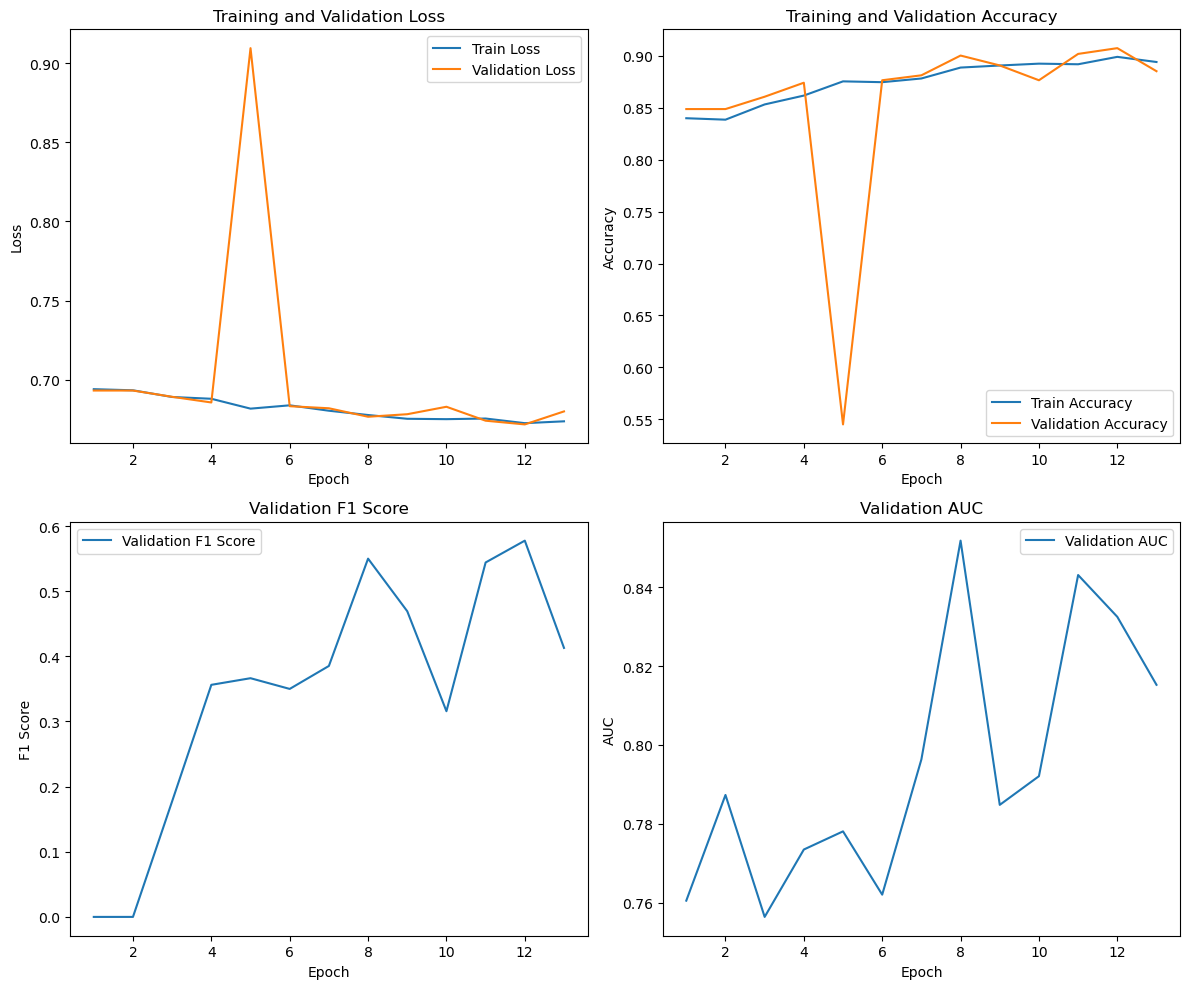

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67174
fold,1
val_accuracy,0.88827
val_auc,0.78492
val_f1,0.42915


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6745, Val Loss = 0.6710, Train Acc = 0.8977, Val Acc = 0.8986, Val F1 = 0.6343, Val AUC = 0.8279
Epoch 2: Train Loss = 0.6745, Val Loss = 0.6699, Train Acc = 0.9035, Val Acc = 0.8938, Val F1 = 0.5649, Val AUC = 0.8225
Epoch 3: Train Loss = 0.6727, Val Loss = 0.6739, Train Acc = 0.9041, Val Acc = 0.8883, Val F1 = 0.5635, Val AUC = 0.8171
Epoch 4: Train Loss = 0.6769, Val Loss = 0.6736, Train Acc = 0.9001, Val Acc = 0.8827, Val F1 = 0.4861, Val AUC = 0.7828
Epoch 5: Train Loss = 0.6761, Val Loss = 0.6821, Train Acc = 0.8922, Val Acc = 0.8590, Val F1 = 0.2937, Val AUC = 0.6642


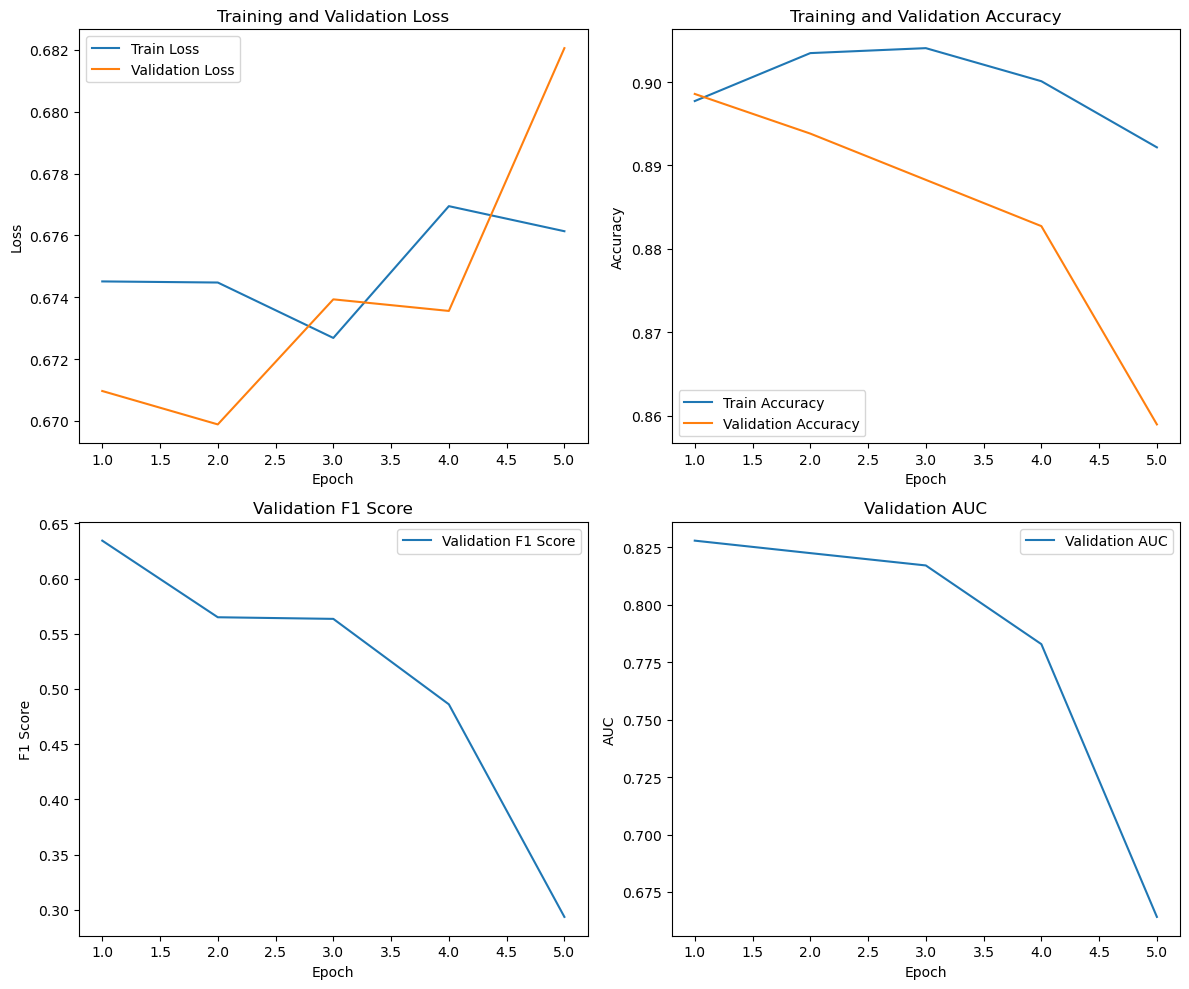

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66988
fold,2
val_accuracy,0.85578
val_auc,0.6675
val_f1,0.26613


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6739, Val Loss = 0.6672, Train Acc = 0.8999, Val Acc = 0.9223, Val F1 = 0.7184, Val AUC = 0.8828
Epoch 2: Train Loss = 0.6720, Val Loss = 0.6729, Train Acc = 0.9047, Val Acc = 0.9167, Val F1 = 0.7244, Val AUC = 0.8807
Epoch 3: Train Loss = 0.6775, Val Loss = 0.6797, Train Acc = 0.8960, Val Acc = 0.9072, Val F1 = 0.7053, Val AUC = 0.8777
Epoch 4: Train Loss = 0.6766, Val Loss = 0.6766, Train Acc = 0.8880, Val Acc = 0.8858, Val F1 = 0.4419, Val AUC = 0.7998


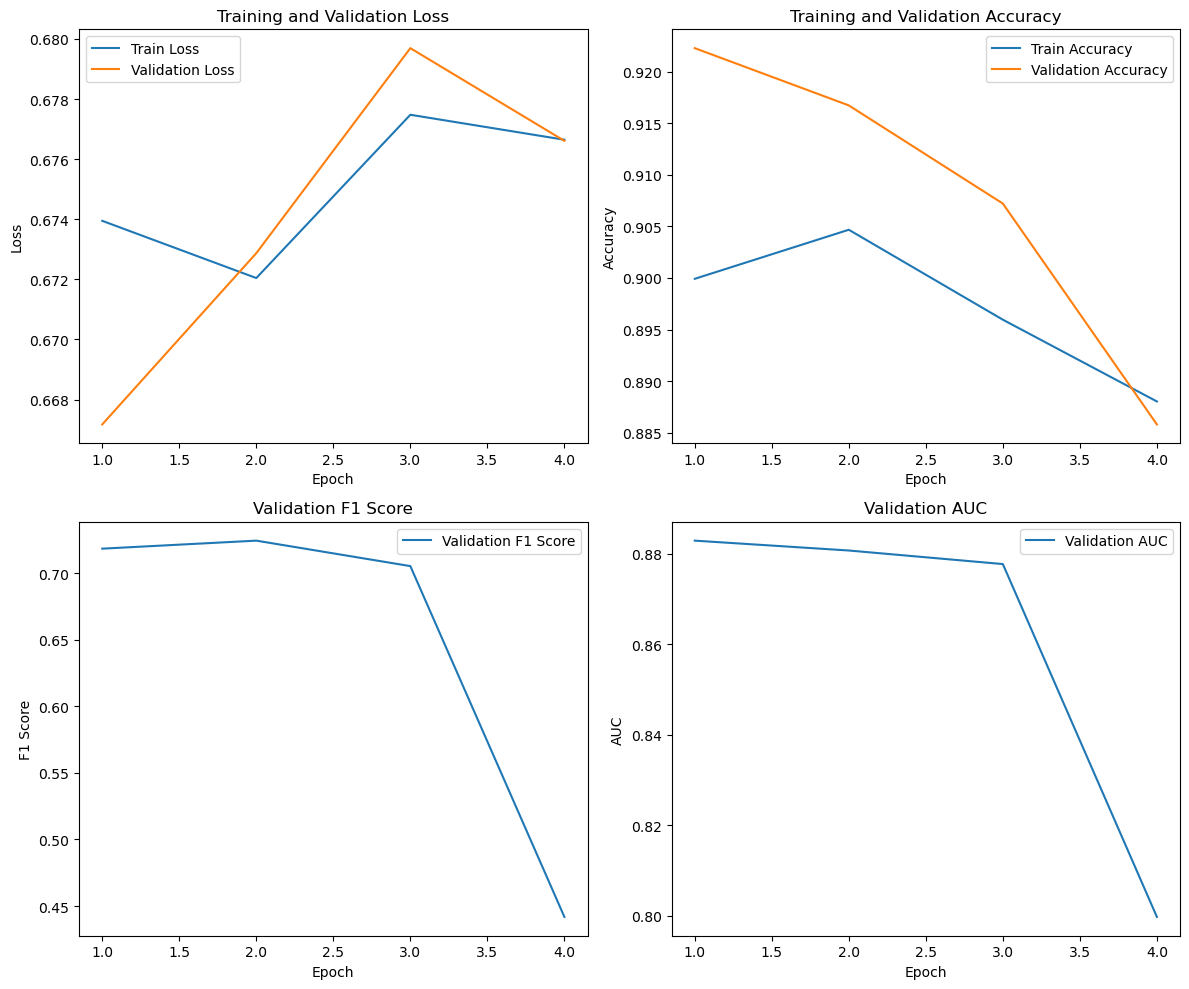

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66717
fold,3
val_accuracy,0.88739
val_auc,0.77029
val_f1,0.45802


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6718, Val Loss = 0.6772, Train Acc = 0.9051, Val Acc = 0.8842, Val F1 = 0.4297, Val AUC = 0.7702
Epoch 2: Train Loss = 0.6724, Val Loss = 0.6719, Train Acc = 0.9076, Val Acc = 0.9120, Val F1 = 0.6819, Val AUC = 0.8875
Epoch 3: Train Loss = 0.6695, Val Loss = 0.6716, Train Acc = 0.9160, Val Acc = 0.9175, Val F1 = 0.7277, Val AUC = 0.8983
Epoch 4: Train Loss = 0.6705, Val Loss = 0.6693, Train Acc = 0.9120, Val Acc = 0.9104, Val F1 = 0.6367, Val AUC = 0.8380
Epoch 5: Train Loss = 0.6699, Val Loss = 0.6725, Train Acc = 0.9082, Val Acc = 0.8961, Val F1 = 0.5201, Val AUC = 0.7897
Epoch 6: Train Loss = 0.6674, Val Loss = 0.6752, Train Acc = 0.9148, Val Acc = 0.8921, Val F1 = 0.5143, Val AUC = 0.8127
Epoch 7: Train Loss = 0.6702, Val Loss = 0.6697, Train Acc = 0.9098, Val Acc = 0.9072, Val F1 = 0.6087, Val AUC = 0.8202


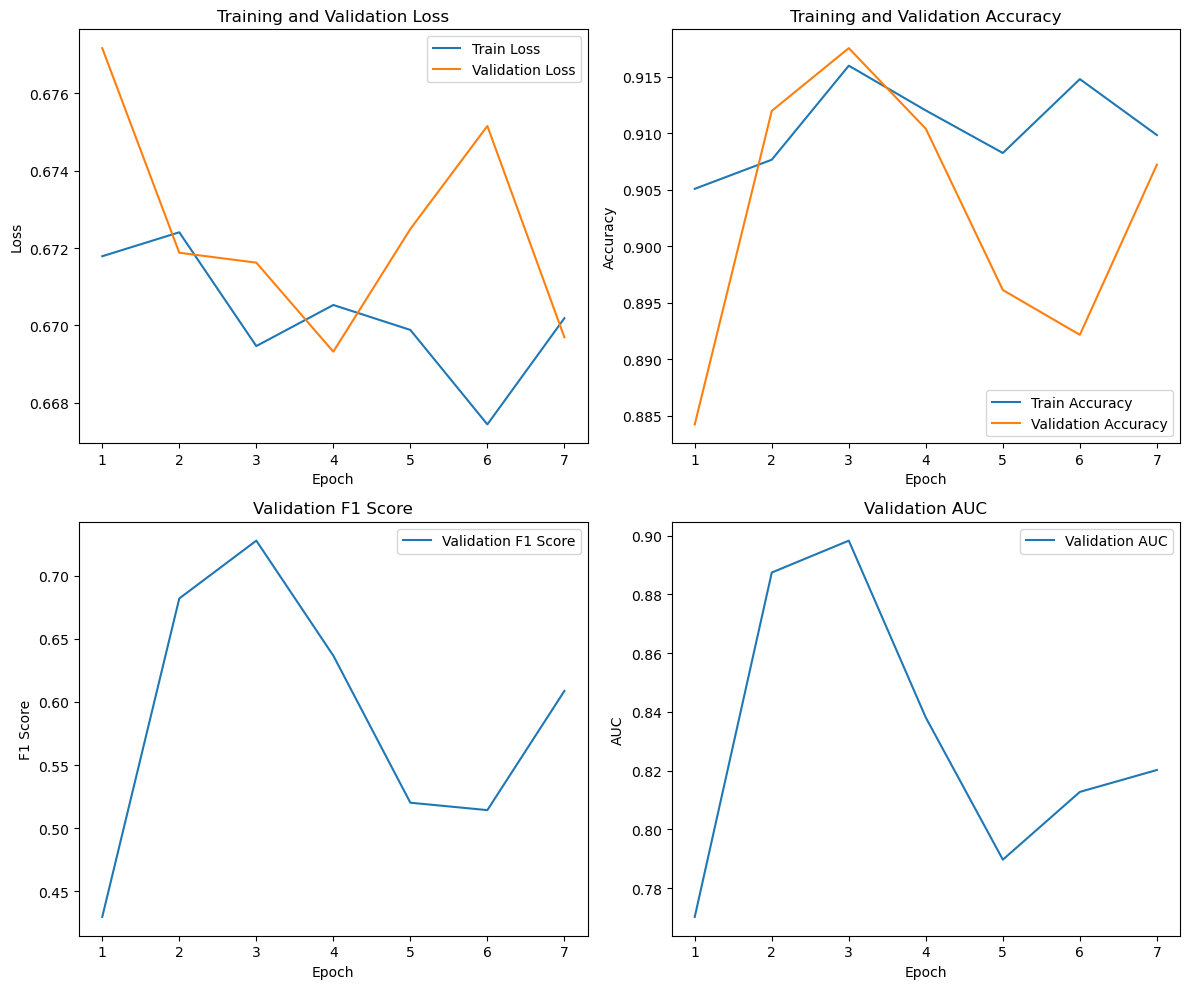

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66932
fold,4
val_accuracy,0.91356
val_auc,0.83283
val_f1,0.64026


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6730, Val Loss = 0.6642, Train Acc = 0.9067, Val Acc = 0.9215, Val F1 = 0.6857, Val AUC = 0.8803
Epoch 2: Train Loss = 0.6768, Val Loss = 0.6728, Train Acc = 0.8922, Val Acc = 0.8969, Val F1 = 0.5221, Val AUC = 0.7725
Epoch 3: Train Loss = 0.6736, Val Loss = 0.6737, Train Acc = 0.8997, Val Acc = 0.8945, Val F1 = 0.5056, Val AUC = 0.7662
Epoch 4: Train Loss = 0.6748, Val Loss = 0.6705, Train Acc = 0.8969, Val Acc = 0.9056, Val F1 = 0.5939, Val AUC = 0.8330


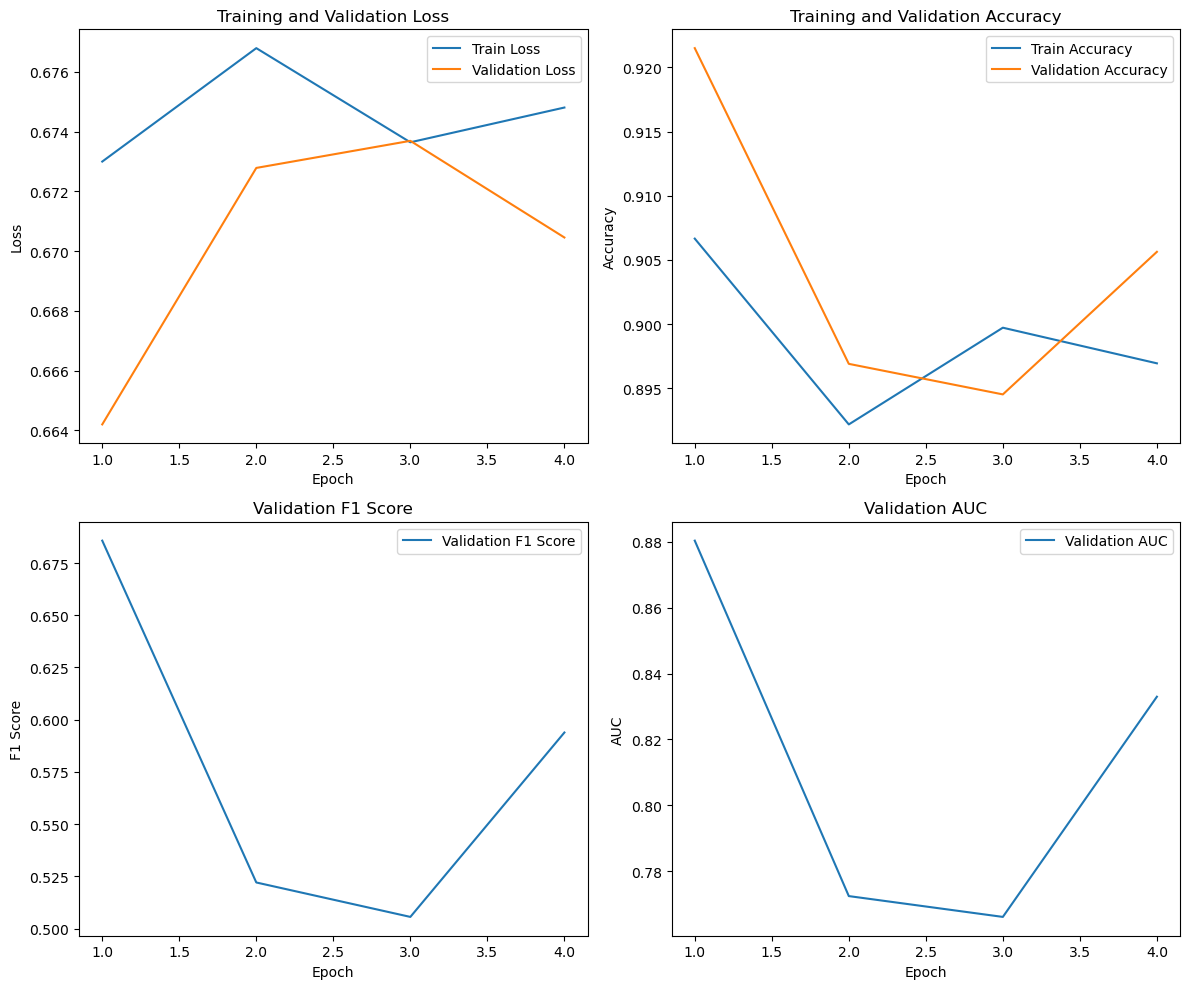

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.6642
fold,5
val_accuracy,0.91039
val_auc,0.81767
val_f1,0.62207


In [6]:
patience = 2
k_folds = 5  
epochs=13


learning_rate=0.000022012211629918463
weight_decay=0.000001549668920821374
batch_size = 4


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_losses = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer_VGG19 = optim.Adam(model_VGG19.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_VGG19 = nn.BCEWithLogitsLoss()

    wandb.init(
        project="Train_VGG19",
        config={
            "model": "VGG19",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"VGG19_fold_{fold+1}"
    )

    best_val_loss_VGG19 = train_model_with_hyperparams(
        model_VGG19, train_loader, val_loader, optimizer_VGG19, criterion_VGG19,
        epochs=epochs, patience=patience
    )
    
    fold_losses.append(best_val_loss_VGG19)
    
    model_VGG19.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_VGG19(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    
    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

   

    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_VGG19,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()






***Train AlexNet***

--- Fold 1/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6923, Val Loss = 0.6851, Train Acc = 0.8442, Val Acc = 0.8716, Val F1 = 0.3306, Val AUC = 0.7306
Epoch 2: Train Loss = 0.6795, Val Loss = 0.6804, Train Acc = 0.8805, Val Acc = 0.8835, Val F1 = 0.4000, Val AUC = 0.8107
Epoch 3: Train Loss = 0.6772, Val Loss = 0.6837, Train Acc = 0.8870, Val Acc = 0.8724, Val F1 = 0.2907, Val AUC = 0.7520
Epoch 4: Train Loss = 0.6766, Val Loss = 0.6808, Train Acc = 0.8864, Val Acc = 0.8851, Val F1 = 0.4402, Val AUC = 0.7862
Epoch 5: Train Loss = 0.6755, Val Loss = 0.7036, Train Acc = 0.8888, Val Acc = 0.8574, Val F1 = 0.4972, Val AUC = 0.7809


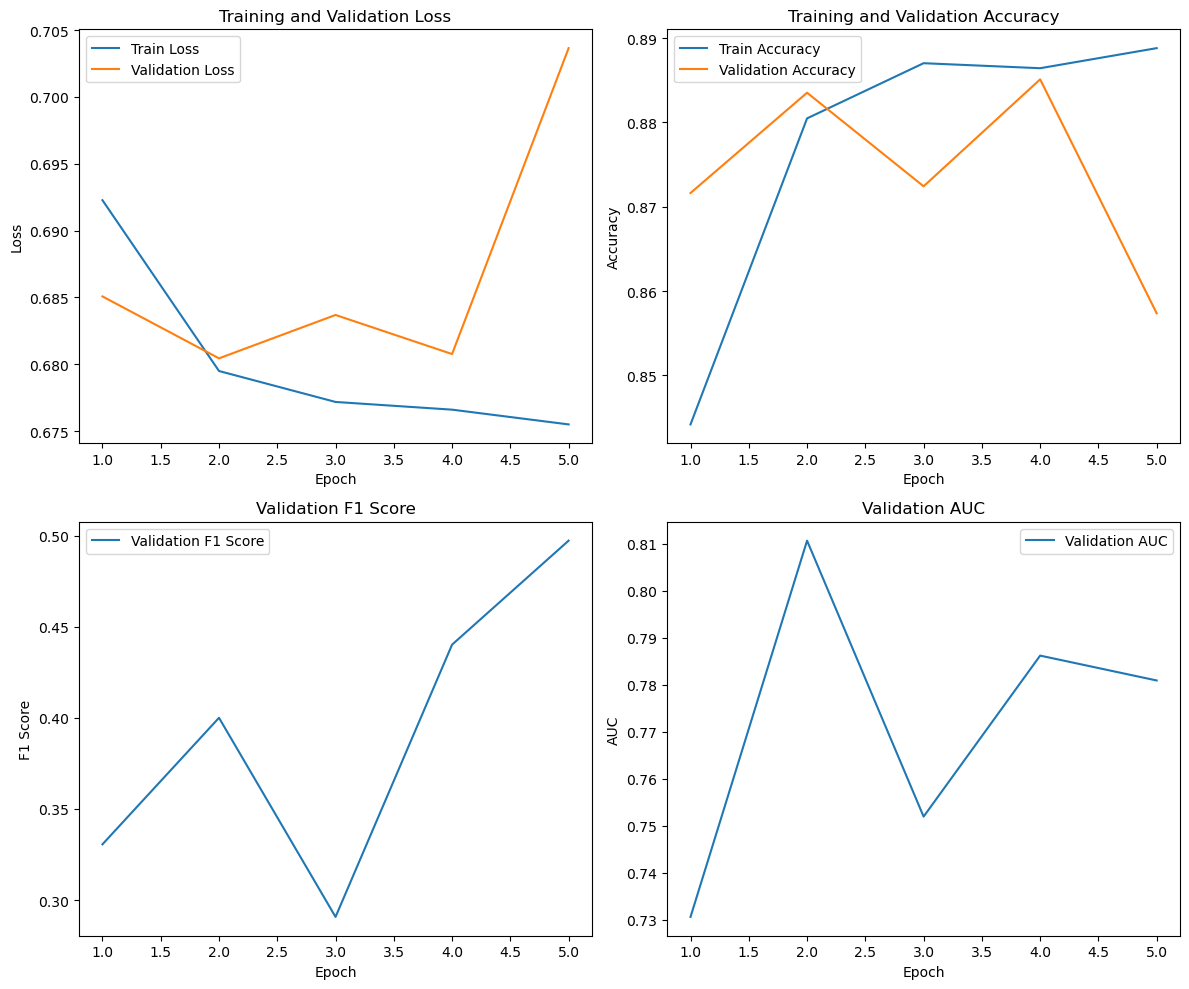

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.68044
fold,1
val_accuracy,0.86292
val_auc,0.78188
val_f1,0.51811


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6764, Val Loss = 0.6754, Train Acc = 0.8918, Val Acc = 0.8796, Val F1 = 0.4830, Val AUC = 0.8131
Epoch 2: Train Loss = 0.6746, Val Loss = 0.6768, Train Acc = 0.8963, Val Acc = 0.8780, Val F1 = 0.4867, Val AUC = 0.8349
Epoch 3: Train Loss = 0.6754, Val Loss = 0.6771, Train Acc = 0.8985, Val Acc = 0.8772, Val F1 = 0.4884, Val AUC = 0.8377
Epoch 4: Train Loss = 0.6769, Val Loss = 0.6806, Train Acc = 0.8918, Val Acc = 0.8653, Val F1 = 0.3750, Val AUC = 0.8154


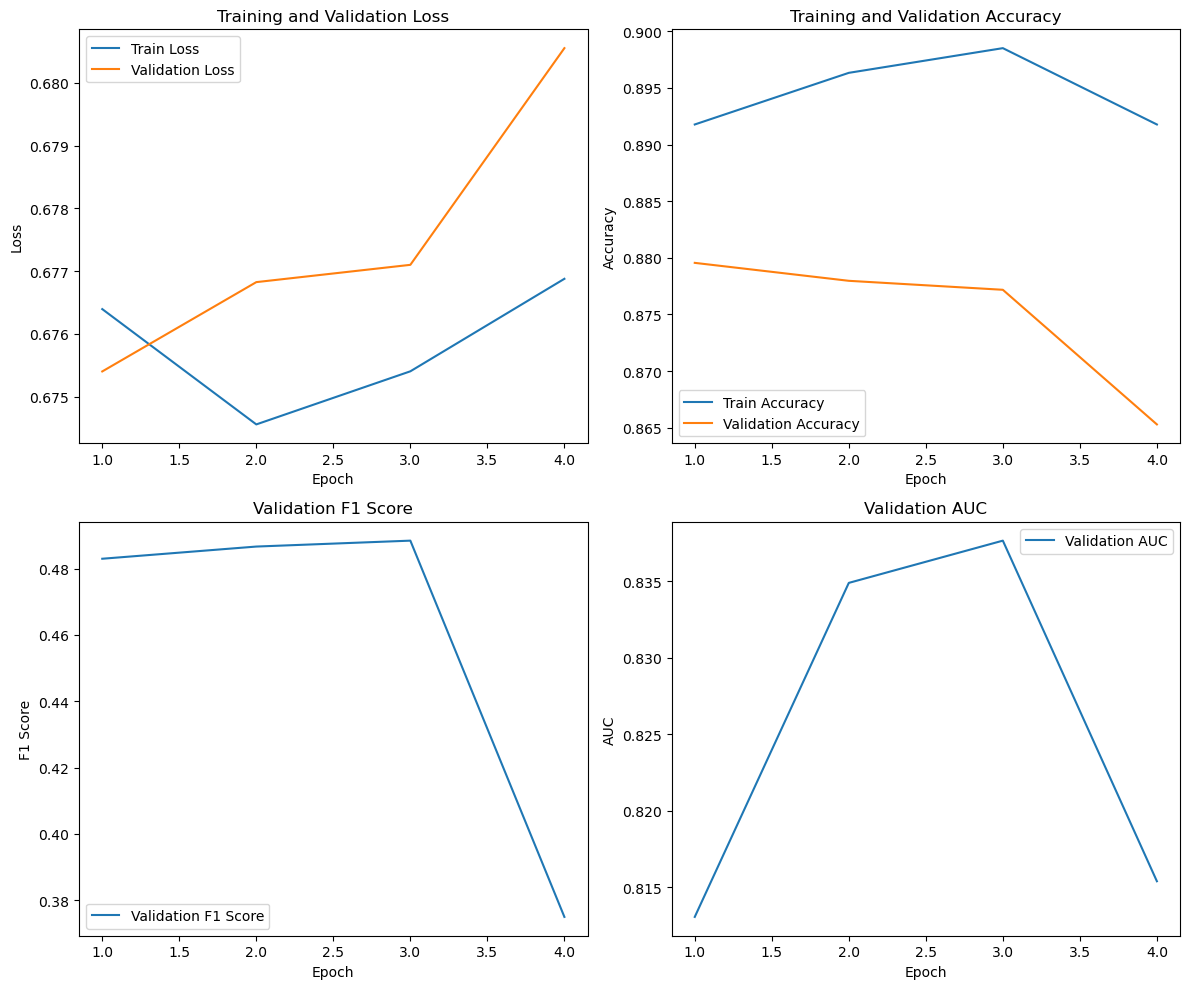

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.6754
fold,2
val_accuracy,0.87163
val_auc,0.81618
val_f1,0.42143


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6766, Val Loss = 0.6711, Train Acc = 0.8888, Val Acc = 0.9159, Val F1 = 0.6989, Val AUC = 0.9107
Epoch 2: Train Loss = 0.6753, Val Loss = 0.6698, Train Acc = 0.8948, Val Acc = 0.9072, Val F1 = 0.6061, Val AUC = 0.8554
Epoch 3: Train Loss = 0.6753, Val Loss = 0.6671, Train Acc = 0.8940, Val Acc = 0.9159, Val F1 = 0.6646, Val AUC = 0.8821
Epoch 4: Train Loss = 0.6757, Val Loss = 0.6822, Train Acc = 0.8898, Val Acc = 0.8723, Val F1 = 0.3320, Val AUC = 0.7862
Epoch 5: Train Loss = 0.6746, Val Loss = 0.6673, Train Acc = 0.8946, Val Acc = 0.9151, Val F1 = 0.6581, Val AUC = 0.8944
Epoch 6: Train Loss = 0.6737, Val Loss = 0.6691, Train Acc = 0.9021, Val Acc = 0.9104, Val F1 = 0.6367, Val AUC = 0.8907


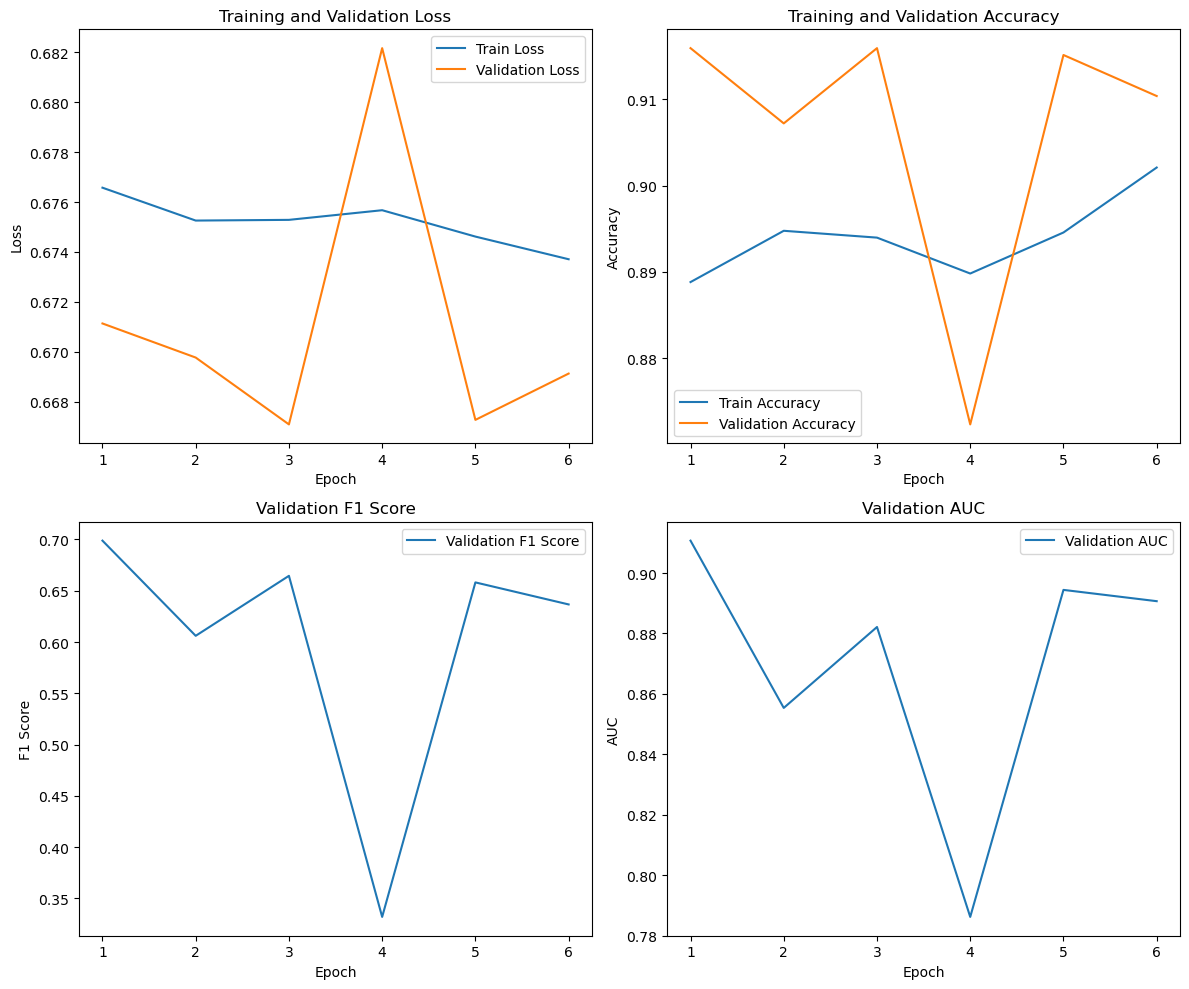

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66709
fold,3
val_accuracy,0.91277
val_auc,0.89015
val_f1,0.64968


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6725, Val Loss = 0.6725, Train Acc = 0.9045, Val Acc = 0.8985, Val F1 = 0.5524, Val AUC = 0.8405
Epoch 2: Train Loss = 0.6715, Val Loss = 0.6725, Train Acc = 0.9015, Val Acc = 0.9088, Val F1 = 0.6547, Val AUC = 0.8888
Epoch 3: Train Loss = 0.6719, Val Loss = 0.6748, Train Acc = 0.9073, Val Acc = 0.8914, Val F1 = 0.4945, Val AUC = 0.7948
Epoch 4: Train Loss = 0.6688, Val Loss = 0.6778, Train Acc = 0.9100, Val Acc = 0.9048, Val F1 = 0.6791, Val AUC = 0.8829
Epoch 5: Train Loss = 0.6696, Val Loss = 0.6752, Train Acc = 0.9078, Val Acc = 0.8898, Val F1 = 0.4794, Val AUC = 0.7640


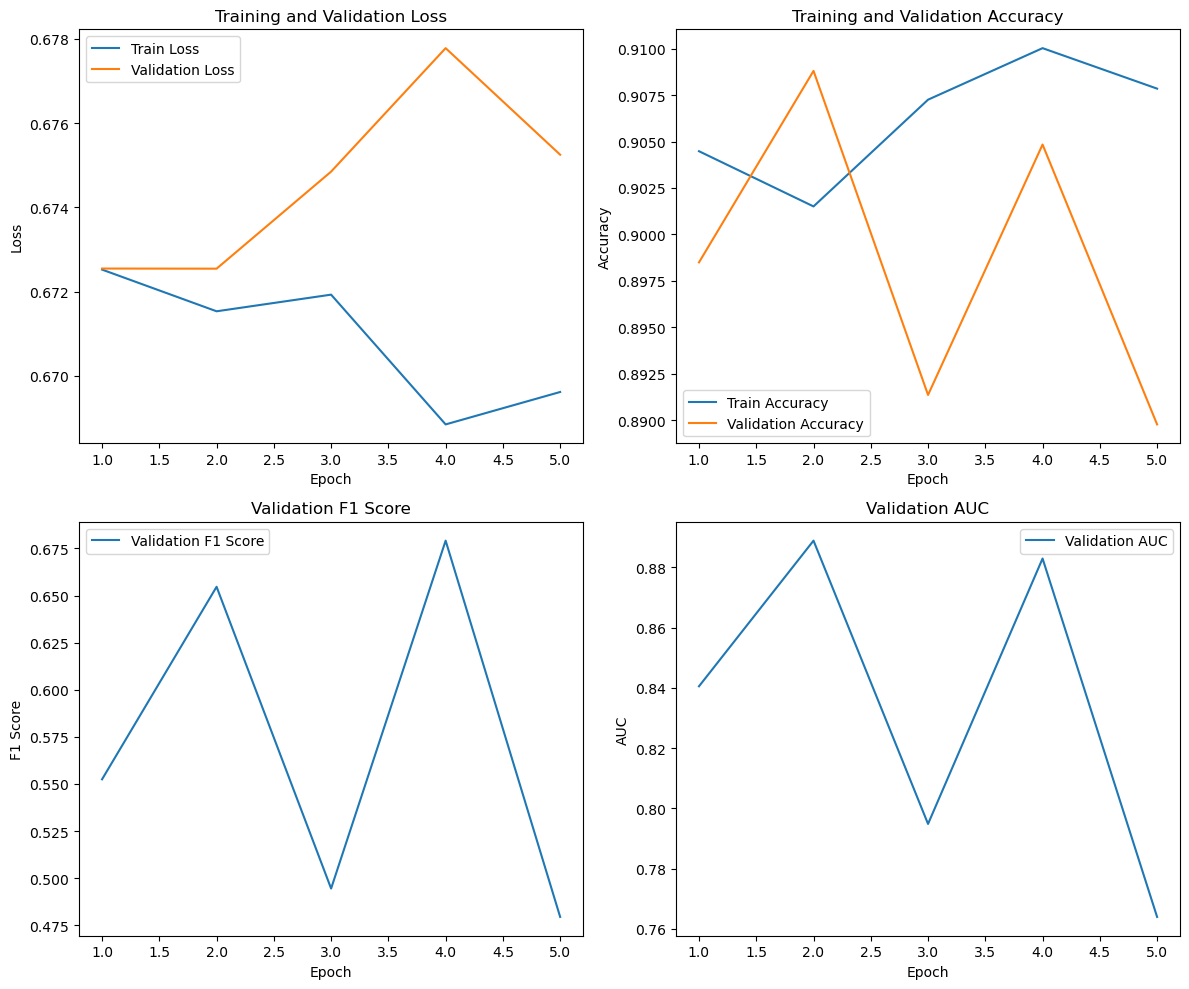

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67254
fold,4
val_accuracy,0.88818
val_auc,0.76197
val_f1,0.46388


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6711, Val Loss = 0.6659, Train Acc = 0.9027, Val Acc = 0.9215, Val F1 = 0.6991, Val AUC = 0.9088
Epoch 2: Train Loss = 0.6714, Val Loss = 0.6672, Train Acc = 0.9017, Val Acc = 0.9175, Val F1 = 0.6770, Val AUC = 0.9193
Epoch 3: Train Loss = 0.6686, Val Loss = 0.6676, Train Acc = 0.9136, Val Acc = 0.9191, Val F1 = 0.6982, Val AUC = 0.9064
Epoch 4: Train Loss = 0.6736, Val Loss = 0.6679, Train Acc = 0.9019, Val Acc = 0.9088, Val F1 = 0.5993, Val AUC = 0.8870


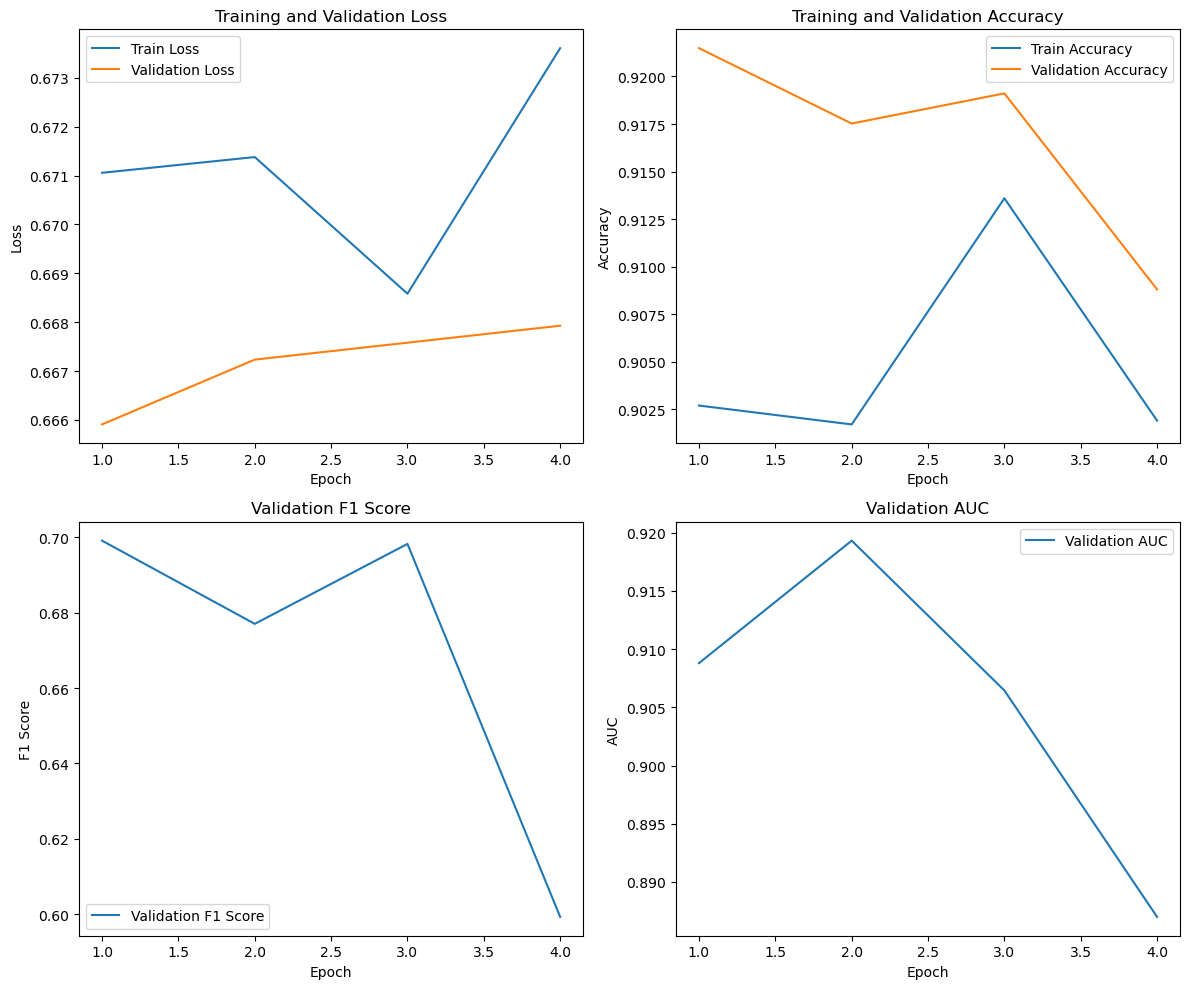

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66591
fold,5
val_accuracy,0.90404
val_auc,0.88336
val_f1,0.58983


In [7]:
patience = 2
k_folds = 5  
epochs=13

batch_size = 8
weight_decay = 1.2852718112074654e-05
learning_rate=3.020842532706549e-05


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_losses = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    optimizer_AlexNet = optim.Adam(model_Alex.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_AlexNet = nn.BCEWithLogitsLoss()

    wandb.init(
        project="Train_AlexNet",
        config={
            "model": "AlexNet",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"Train_AlexNet{fold+1}"
    )

    best_val_loss_AlexNet = train_model_with_hyperparams(
        model_Alex, train_loader, val_loader, optimizer_AlexNet, criterion_AlexNet, epochs=epochs, patience=patience
    )

    fold_losses.append(best_val_loss_AlexNet)

 
    model_Alex.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_Alex(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_AlexNet,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()


